![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Format meteo data for upload to FLUXNET
</b>
</span>

---
**Notebook version**: `1` (26 Feb 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Formats meteo data to comply with FLUXNET requirements for data upload

More info:
- [EFDC: Data submission - General Information](http://gaia.agraria.unitus.it/home/guidelines/how-to-submit-data/general-information)

</br>

# **Settings**

## Variables

In [1]:
# Name of the variables in the database used in this example
FIELDS = [
        'TA_T1_2_1',
        'RH_T1_2_1',
        'SW_IN_T1_1_1',
        'SW_OUT_T1_1_1',
        'LW_IN_T1_1_1',
        'LW_OUT_T1_1_1',
        'PPFD_IN_T1_2_1',
        'PPFD_OUT_T1_2_1',
        'TS_GF1_0.01_1',
        'TS_GF1_0.04_1',
        'TS_GF1_0.07_1',
        'TS_GF1_0.1_2',
        'TS_GF1_0.15_1',
        'TS_GF1_0.2_2',
        'TS_GF1_0.25_1',
        'TS_GF1_0.3_2',
        'TS_GF1_0.4_1',
        'TS_GF1_0.5_2',
        'TS_GF1_0.95_1',
        'TS_GF1_1_2',
        'SWC_GF1_0.05_1',
        'SWC_GF1_0.15_1',
        'SWC_GF1_0.25_1',
        'SWC_GF1_0.4_1',
        'SWC_GF1_0.95_1',
        'PREC_TOT_GF1_1_1',
        'G_GF1_0.06_1',
        'G_GF1_0.06_2'
    ]

# Rename original variables (from the database) to FLUXNET variable names
rename_dict = {
        'TA_T1_2_1': 'TA_1_1_1',
        'RH_T1_2_1': 'RH_1_1_1',
        'SW_IN_T1_1_1': 'SW_IN_1_1_1',
        'SW_OUT_T1_1_1': 'SW_OUT_1_1_1',
        'LW_IN_T1_1_1': 'LW_IN_1_1_1',
        'LW_OUT_T1_1_1': 'LW_OUT_1_1_1',
        'PPFD_IN_T1_2_1': 'PPFD_IN_1_1_1',
        'PPFD_OUT_T1_2_1': 'PPFD_OUT_1_1_1',
        'TS_GF1_0.01_1': 'TS_1_1_1',
        'TS_GF1_0.04_1': 'TS_1_2_1',
        'TS_GF1_0.07_1': 'TS_1_3_1',
        'TS_GF1_0.1_2': 'TS_1_4_2',
        'TS_GF1_0.15_1': 'TS_1_5_1',
        'TS_GF1_0.2_2': 'TS_1_6_1',
        'TS_GF1_0.25_1': 'TS_1_7_1',
        'TS_GF1_0.3_2': 'TS_1_8_1',
        'TS_GF1_0.4_1': 'TS_1_9_1',
        'TS_GF1_0.5_2': 'TS_1_10_1',
        'TS_GF1_0.95_1': 'TS_1_11_1',
        'TS_GF1_1_2': 'TS_1_12_1',
        'SWC_GF1_0.05_1': 'SWC_1_1_1',
        'SWC_GF1_0.15_1': 'SWC_1_2_1',
        'SWC_GF1_0.25_1': 'SWC_1_3_1',
        'SWC_GF1_0.4_1': 'SWC_1_4_1',
        'SWC_GF1_0.95_1': 'SWC_1_5_1',
        'PREC_TOT_T1_0.5_1+PREC_TOT_GF1_1_1': 'P_1_1_1',
        'G_GF1_0.06_1': 'G_1_1_1',
        'G_GF1_0.06_2': 'G_1_1_2'
    }

## Database settings (used for example data)

In [2]:
# Settings for database download
SITE = 'ch-fru'  # Site name
START = '2024-01-01 00:01:00'  # Download data starting with this date
STOP = '2025-01-01 00:01:00'  # Download data before this date (the stop date itself is not included)
DATA_VERSION = 'meteoscreening_diive'
MEASUREMENTS = ['TA', 'RH', 'SW', 'PPFD', 'LW', 'TS', 'SWC', 'PREC', 'G']
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
data_version = "meteoscreening_diive"
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'

</br>

# **Imports**

In [3]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from dbc_influxdb import dbcInflux

from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # For plotting heatmaps
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.formats.meteo import FormatMeteoForFluxnetUpload  # Class to format output files for upload

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.6


</br>

# **Docstring**

In [4]:
# help(FormatMeteoForEddyProProcessing)

</br>

# **Load example data**
- This example uses data from a database.

In [5]:
dbc = dbcInflux(dirconf=DIRCONF)
df, _, _ = \
    dbc.download(bucket=f'{SITE}_processed',
                 measurements=MEASUREMENTS,
                 fields=FIELDS,
                 start=START,
                 stop=STOP,
                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                 data_version=DATA_VERSION)

Reading configuration files was successful.
Connection to database works.

DOWNLOADING
    from bucket ch-fru_processed
    variables ['TA_T1_2_1', 'RH_T1_2_1', 'SW_IN_T1_1_1', 'SW_OUT_T1_1_1', 'LW_IN_T1_1_1', 'LW_OUT_T1_1_1', 'PPFD_IN_T1_2_1', 'PPFD_OUT_T1_2_1', 'TS_GF1_0.01_1', 'TS_GF1_0.04_1', 'TS_GF1_0.07_1', 'TS_GF1_0.1_2', 'TS_GF1_0.15_1', 'TS_GF1_0.2_2', 'TS_GF1_0.25_1', 'TS_GF1_0.3_2', 'TS_GF1_0.4_1', 'TS_GF1_0.5_2', 'TS_GF1_0.95_1', 'TS_GF1_1_2', 'SWC_GF1_0.05_1', 'SWC_GF1_0.15_1', 'SWC_GF1_0.25_1', 'SWC_GF1_0.4_1', 'SWC_GF1_0.95_1', 'PREC_TOT_GF1_1_1', 'G_GF1_0.06_1', 'G_GF1_0.06_2']
    from measurements ['TA', 'RH', 'SW', 'PPFD', 'LW', 'TS', 'SWC', 'PREC', 'G']
    from data version meteoscreening_diive
    between 2024-01-01 00:01:00 and 2025-01-01 00:01:00
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-fru_processed") |> range(start: 2024-01-01T00:01:00+01:00, stop: 2025-01-01T00:01:00+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_m

The dataframe with original data looks like this:

In [6]:
df

,G_GF1_0.06_1,G_GF1_0.06_2,LW_IN_T1_1_1,LW_OUT_T1_1_1,PPFD_IN_T1_2_1,PPFD_OUT_T1_2_1,PREC_TOT_GF1_1_1,RH_T1_2_1,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.25_1,SWC_GF1_0.4_1,SWC_GF1_0.95_1,SW_IN_T1_1_1,SW_OUT_T1_1_1,TA_T1_2_1,TS_GF1_0.01_1,TS_GF1_0.04_1,TS_GF1_0.07_1,TS_GF1_0.15_1,TS_GF1_0.1_2,TS_GF1_0.25_1,TS_GF1_0.2_2,TS_GF1_0.3_2,TS_GF1_0.4_1,TS_GF1_0.5_2,TS_GF1_0.95_1,TS_GF1_1_2
TIMESTAMP_END,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:30:00,-11.327425,-11.049985,298.680643,307.044110,0.0,0.0,0.0,99.997990,50.011900,48.853440,50.173923,51.266751,52.777335,0.0,0.0,0.063089,2.597757,2.832555,3.143097,3.461969,2.656696,4.005273,3.289952,3.734486,4.325761,4.658168,5.207891,5.482726
2024-01-01 01:00:00,-11.790581,-11.655902,269.906123,306.405987,0.0,0.0,0.0,98.689082,49.857068,48.771419,50.063437,51.195040,52.764266,0.0,0.0,0.365761,2.559552,2.802053,3.118618,3.449898,2.632535,3.993614,3.277455,3.717295,4.326126,4.658168,5.207497,5.480697
2024-01-01 01:30:00,-12.297556,-12.115573,241.274010,306.767957,0.0,0.0,0.0,95.548050,49.709652,48.698809,49.953730,51.145288,52.752185,0.0,0.0,0.326444,2.515746,2.767428,3.095484,3.435626,2.598587,3.982241,3.262319,3.715972,4.321674,4.658838,5.208134,5.482726
2024-01-01 02:00:00,-12.763394,-12.435223,228.099020,305.732020,0.0,0.0,0.0,89.946188,49.569639,48.638513,49.861592,51.105192,52.727138,0.0,0.0,0.767750,2.467116,2.725764,3.066594,3.420452,2.563330,3.973189,3.246534,3.713989,4.320773,4.656165,5.207816,5.483403
2024-01-01 02:30:00,-13.177035,-12.691166,251.443823,307.650857,0.0,0.0,0.0,85.651175,49.431652,48.575103,49.774011,51.045439,52.698879,0.0,0.0,1.136206,2.417023,2.687162,3.035753,3.404396,2.529397,3.962704,3.226814,3.698781,4.314314,4.651483,5.207657,5.484079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,-6.896756,-6.284012,227.565077,265.189837,0.0,0.0,0.0,49.185175,61.780803,51.267053,50.217804,52.459795,52.386474,0.0,0.0,2.144256,1.638711,1.775236,2.165017,2.285103,1.930993,2.943035,2.420493,2.846359,3.406129,3.919832,4.700538,5.240322
2024-12-31 22:30:00,-6.897304,-6.290326,227.376887,264.182430,0.0,0.0,0.0,44.889381,61.790680,51.275753,50.223797,52.463096,52.382301,0.0,0.0,3.363916,1.637200,1.772781,2.161631,2.281670,1.930993,2.945709,2.417234,2.842432,3.399110,3.920494,4.700398,5.245044
2024-12-31 23:00:00,-6.897327,-6.346511,226.851997,266.966060,0.0,0.0,0.0,42.483432,61.796633,51.282005,50.232441,52.468549,52.372637,0.0,0.0,4.349011,1.635932,1.769311,2.159314,2.278250,1.934887,2.945343,2.422450,2.841777,3.395493,3.913211,4.699080,5.242346


</br>

# **Apply formatting**

In [7]:
f = FormatMeteoForFluxnetUpload(
    df=df,
    cols=rename_dict
)
f.run()


Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_END ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_END to datetime ... OK
>>> All rows have timestamp TIMESTAMP_END, no rows removed.
>>> Sorting timestamp TIMESTAMP_END ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30min time resolution with HIGH confidence.
   Resolution detected from most frequent timestep (timedelta):
       from full data = None / -failed- (not used)
       from timedelta = 30min / 100% occurrence (OK)
       from progressive = 30min / data 893+893 (not used)

>>> Creating continuous 30min timestamp index for timestamp TIMESTAMP_END between 2024-01-01 00:30:00 and 2025-01-01 00:00:00 ...
>>> Converting timestamp index TIMESTAMP_END to show middle of averaging period ...
    TIMESTAMP_END was converted to TIMESTAMP_MIDDLE
    First

In [8]:
res = f.get_results()
res

,TIMESTAMP_START,TIMESTAMP_END,G_1_1_1,G_1_1_2,LW_IN_1_1_1,LW_OUT_1_1_1,PPFD_IN_1_1_1,PPFD_OUT_1_1_1,PREC_TOT_GF1_1_1,RH_1_1_1,SWC_1_1_1,SWC_1_2_1,SWC_1_3_1,SWC_1_4_1,SWC_1_5_1,SW_IN_1_1_1,SW_OUT_1_1_1,TA_1_1_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_5_1,TS_1_4_2,TS_1_7_1,TS_1_6_1,TS_1_8_1,TS_1_9_1,TS_1_10_1,TS_1_11_1,TS_1_12_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:15:00,202401010000,202401010030,-11.327425,-11.049985,298.680643,307.044110,0.0,0.0,0.0,99.997990,50.011900,48.853440,50.173923,51.266751,52.777335,0.0,0.0,0.063089,2.597757,2.832555,3.143097,3.461969,2.656696,4.005273,3.289952,3.734486,4.325761,4.658168,5.207891,5.482726
2024-01-01 00:45:00,202401010030,202401010100,-11.790581,-11.655902,269.906123,306.405987,0.0,0.0,0.0,98.689082,49.857068,48.771419,50.063437,51.195040,52.764266,0.0,0.0,0.365761,2.559552,2.802053,3.118618,3.449898,2.632535,3.993614,3.277455,3.717295,4.326126,4.658168,5.207497,5.480697
2024-01-01 01:15:00,202401010100,202401010130,-12.297556,-12.115573,241.274010,306.767957,0.0,0.0,0.0,95.548050,49.709652,48.698809,49.953730,51.145288,52.752185,0.0,0.0,0.326444,2.515746,2.767428,3.095484,3.435626,2.598587,3.982241,3.262319,3.715972,4.321674,4.658838,5.208134,5.482726
2024-01-01 01:45:00,202401010130,202401010200,-12.763394,-12.435223,228.099020,305.732020,0.0,0.0,0.0,89.946188,49.569639,48.638513,49.861592,51.105192,52.727138,0.0,0.0,0.767750,2.467116,2.725764,3.066594,3.420452,2.563330,3.973189,3.246534,3.713989,4.320773,4.656165,5.207816,5.483403
2024-01-01 02:15:00,202401010200,202401010230,-13.177035,-12.691166,251.443823,307.650857,0.0,0.0,0.0,85.651175,49.431652,48.575103,49.774011,51.045439,52.698879,0.0,0.0,1.136206,2.417023,2.687162,3.035753,3.404396,2.529397,3.962704,3.226814,3.698781,4.314314,4.651483,5.207657,5.484079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,202412312130,202412312200,-6.896756,-6.284012,227.565077,265.189837,0.0,0.0,0.0,49.185175,61.780803,51.267053,50.217804,52.459795,52.386474,0.0,0.0,2.144256,1.638711,1.775236,2.165017,2.285103,1.930993,2.943035,2.420493,2.846359,3.406129,3.919832,4.700538,5.240322
2024-12-31 22:15:00,202412312200,202412312230,-6.897304,-6.290326,227.376887,264.182430,0.0,0.0,0.0,44.889381,61.790680,51.275753,50.223797,52.463096,52.382301,0.0,0.0,3.363916,1.637200,1.772781,2.161631,2.281670,1.930993,2.945709,2.417234,2.842432,3.399110,3.920494,4.700398,5.245044
2024-12-31 22:45:00,202412312230,202412312300,-6.897327,-6.346511,226.851997,266.966060,0.0,0.0,0.0,42.483432,61.796633,51.282005,50.232441,52.468549,52.372637,0.0,0.0,4.349011,1.635932,1.769311,2.159314,2.278250,1.934887,2.945343,2.422450,2.841777,3.395493,3.913211,4.699080,5.242346


</br>

# **Plot all variables**

C:\Users\holukas\AppData\Local\Temp\ipykernel_21972\2346495405.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='white', figsize=(4, 8))


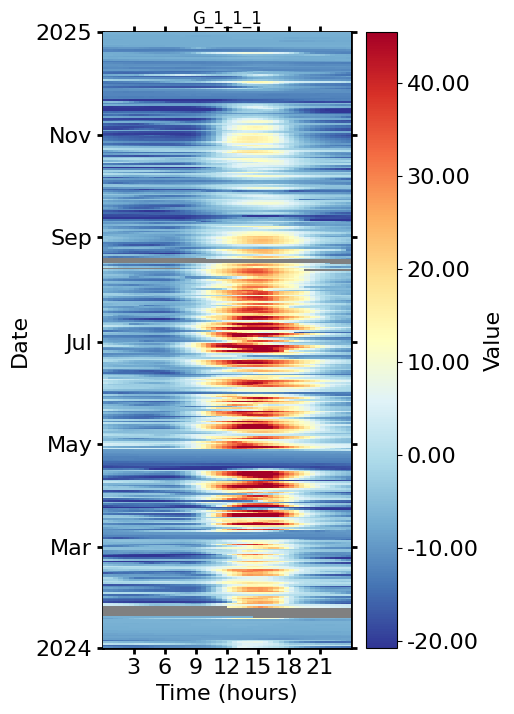

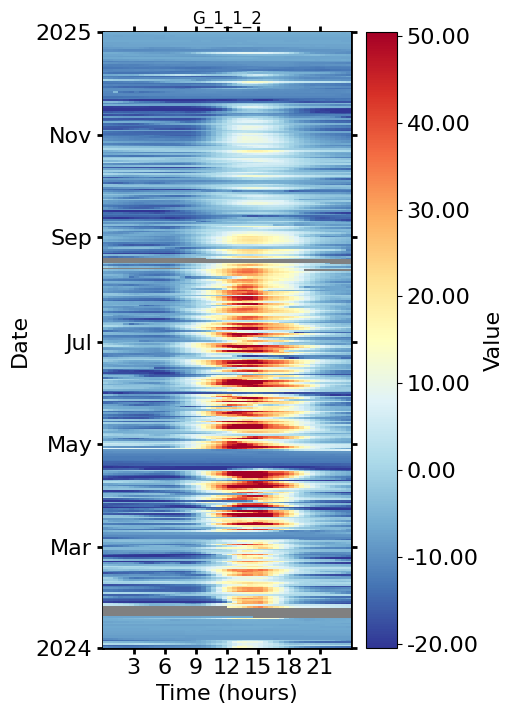

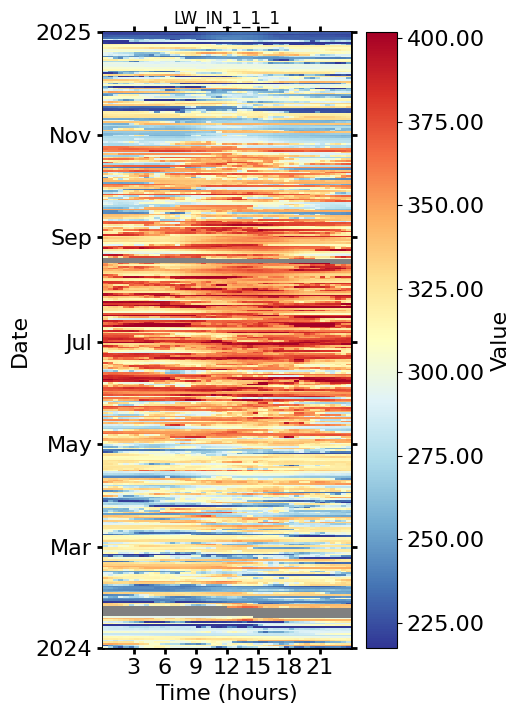

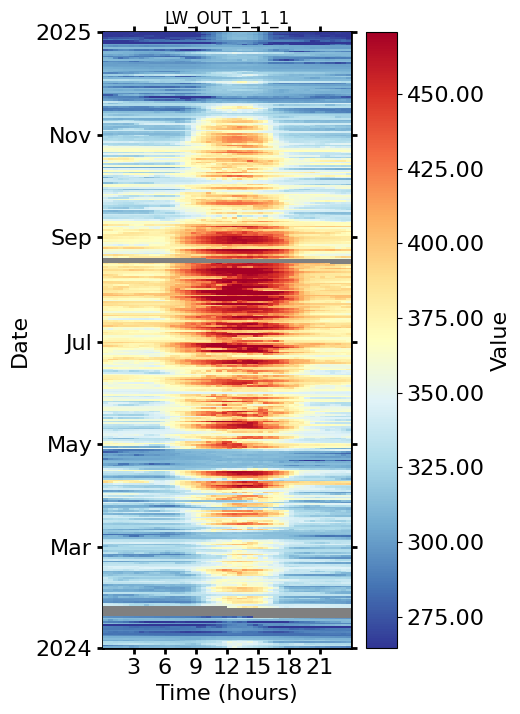

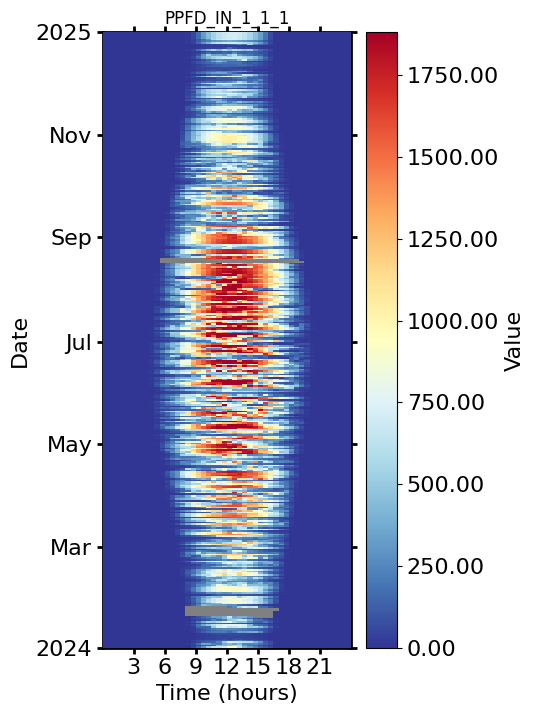

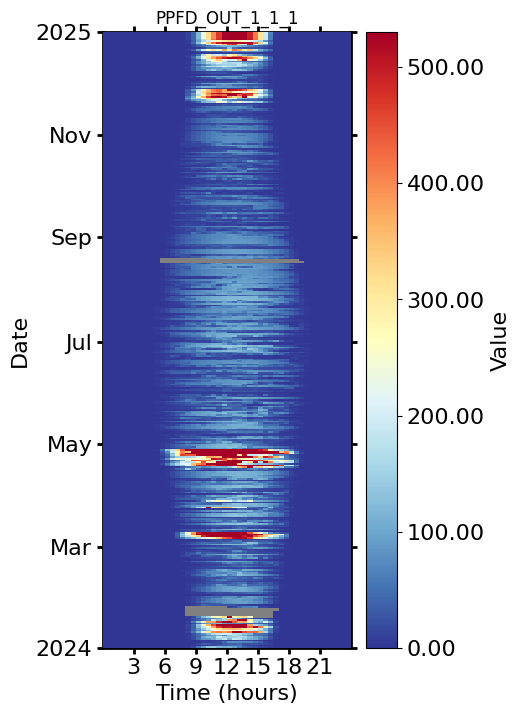

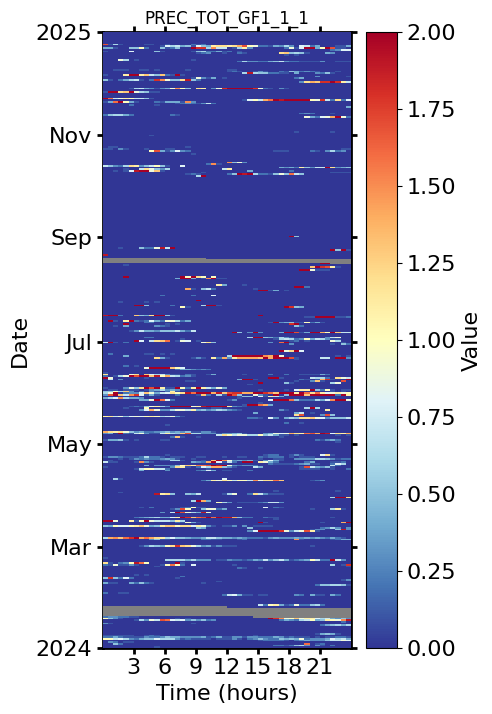

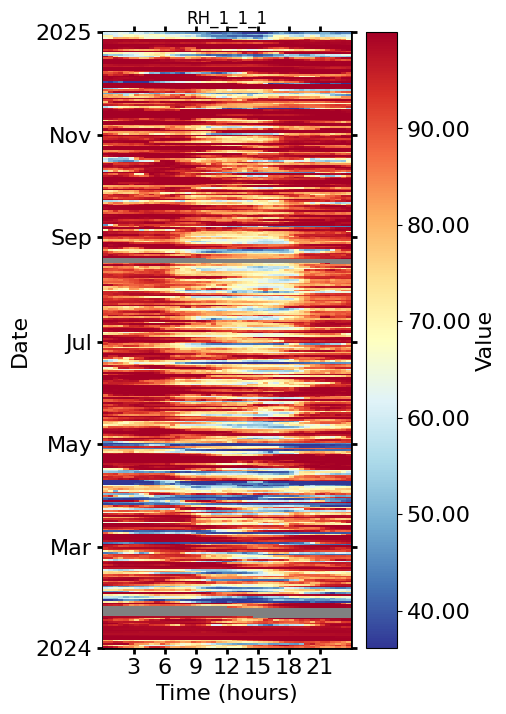

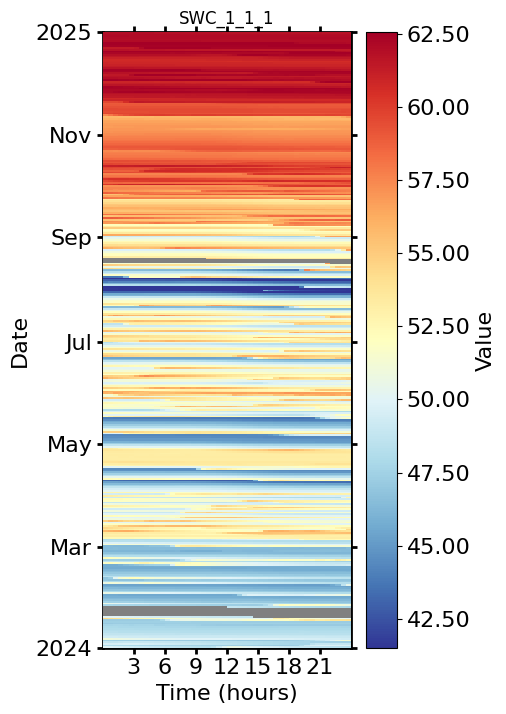

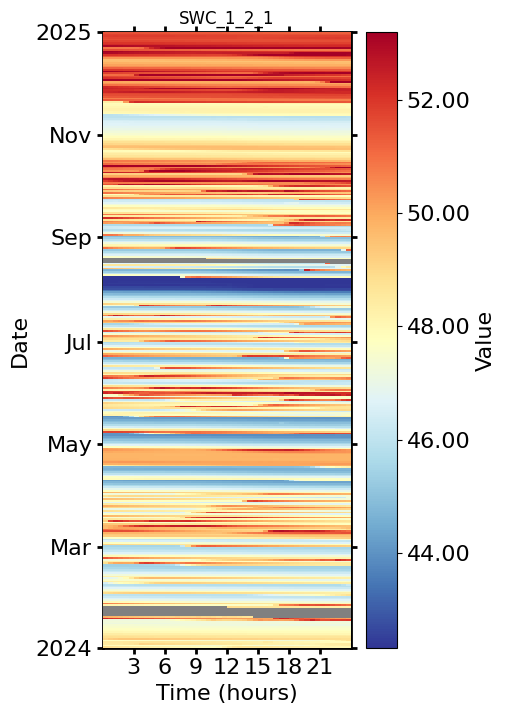

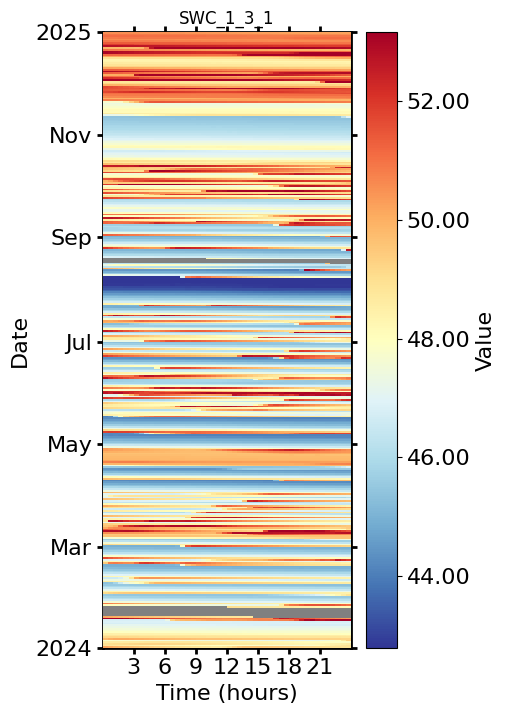

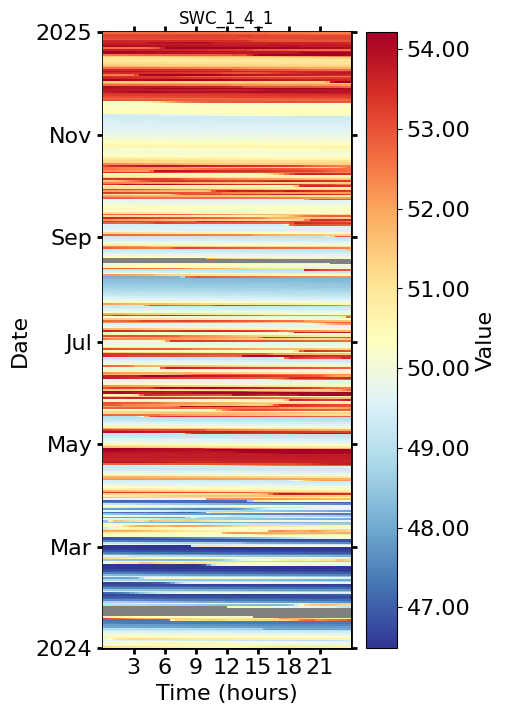

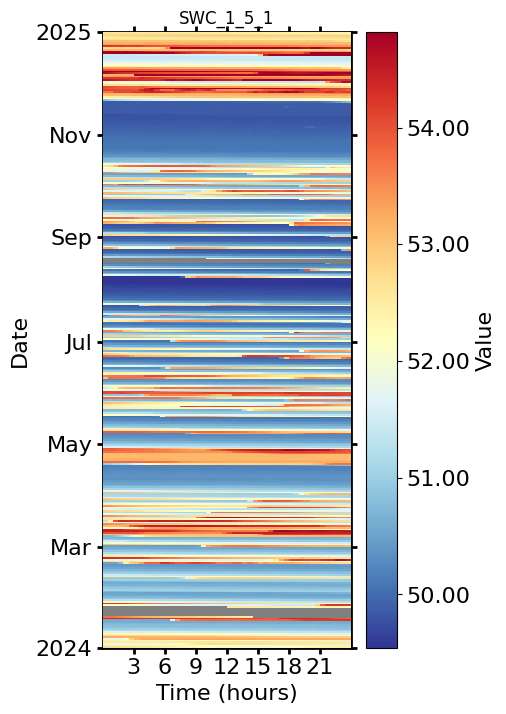

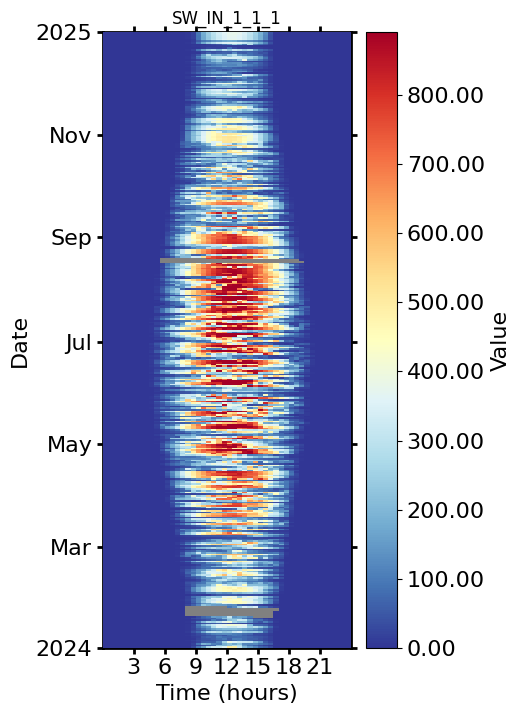

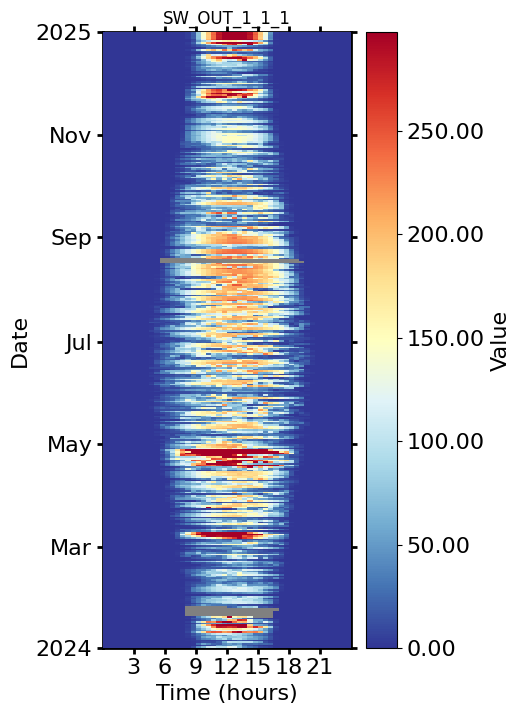

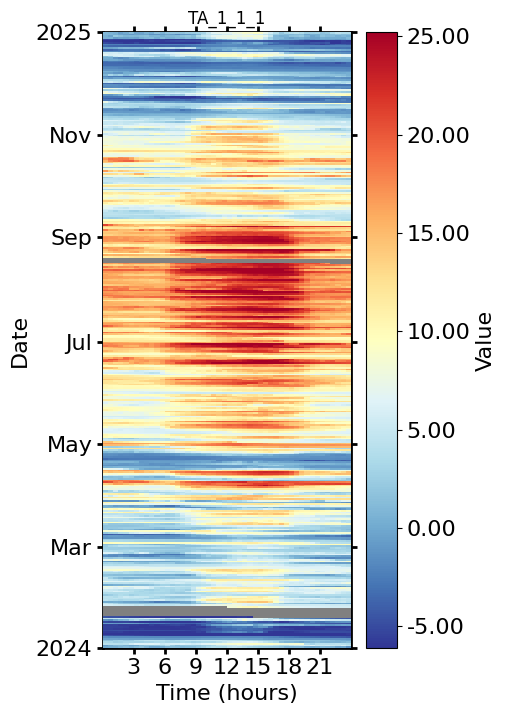

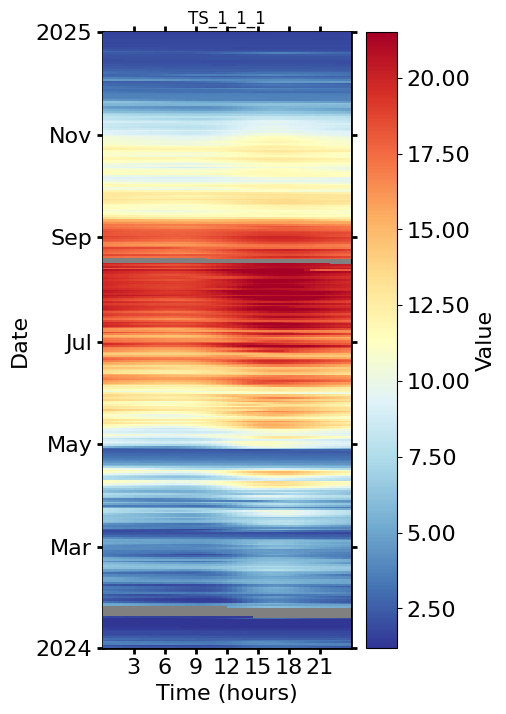

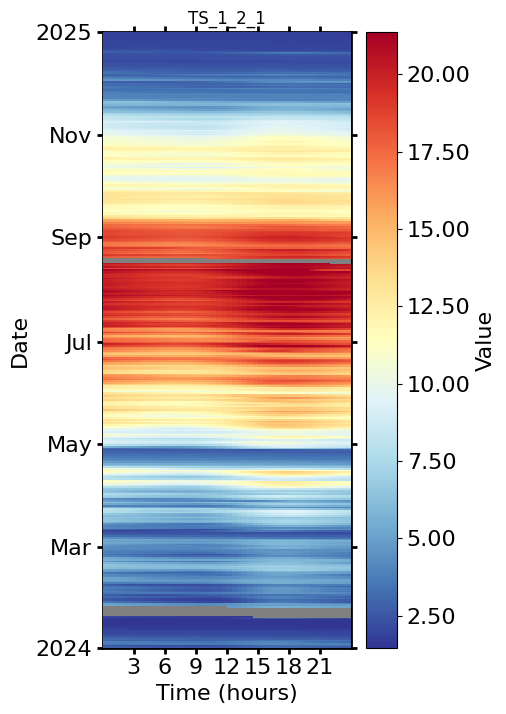

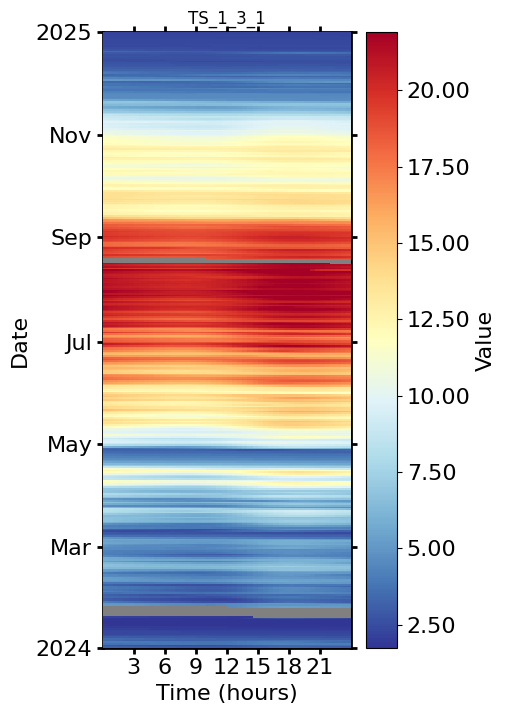

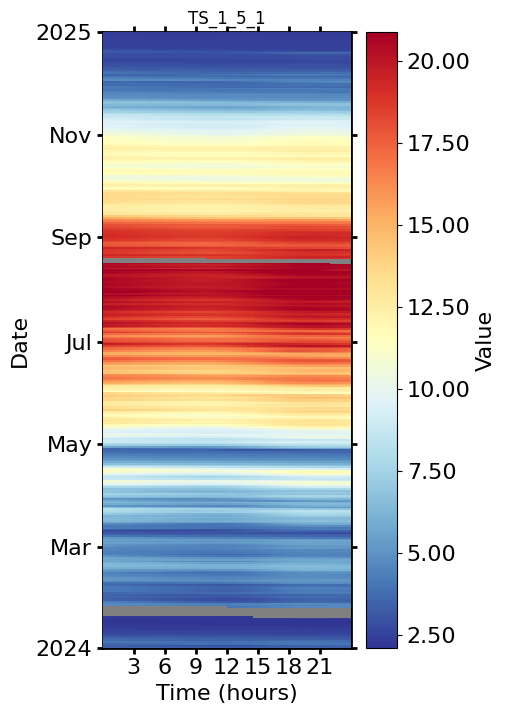

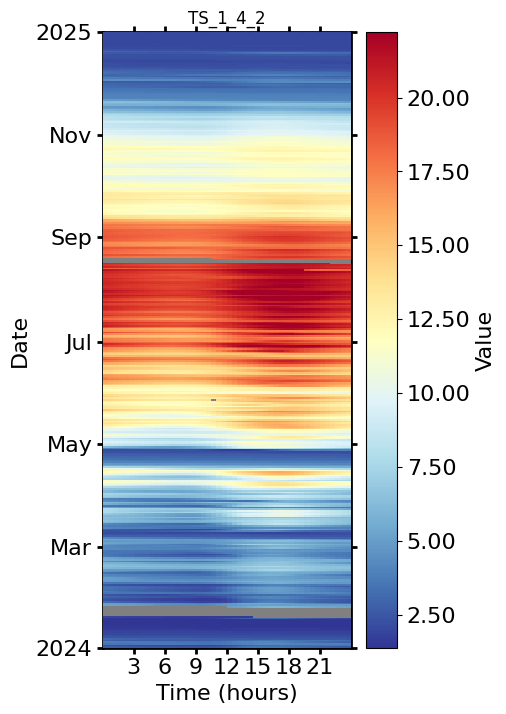

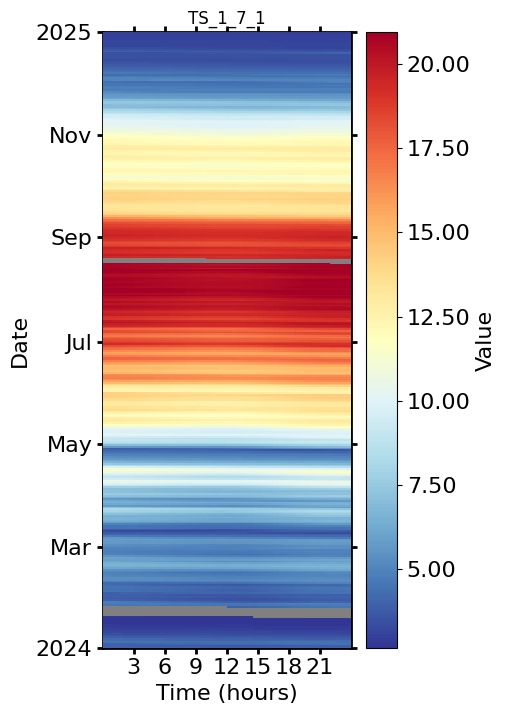

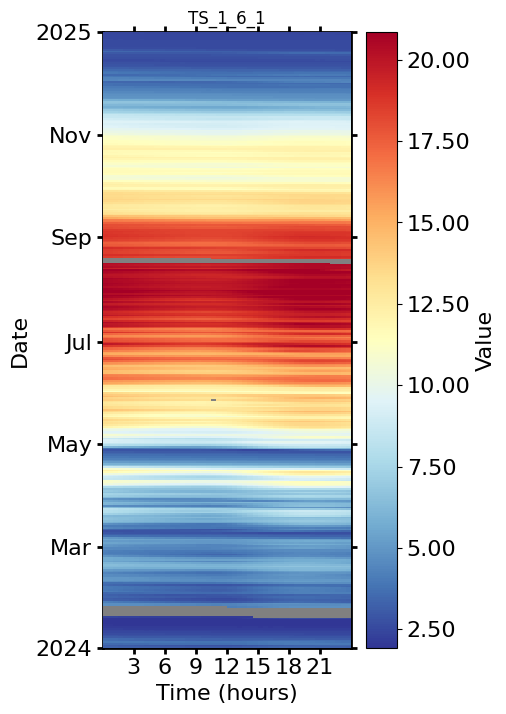

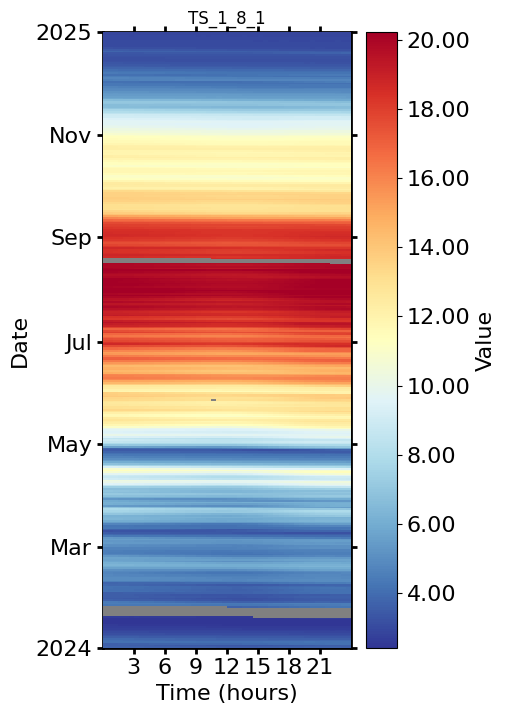

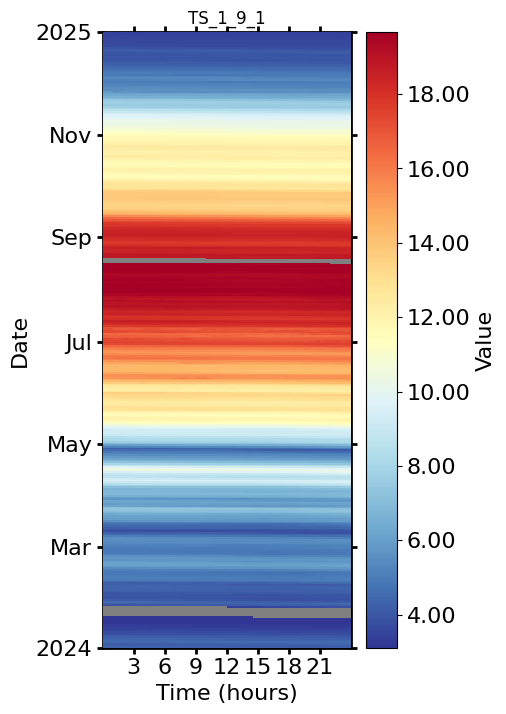

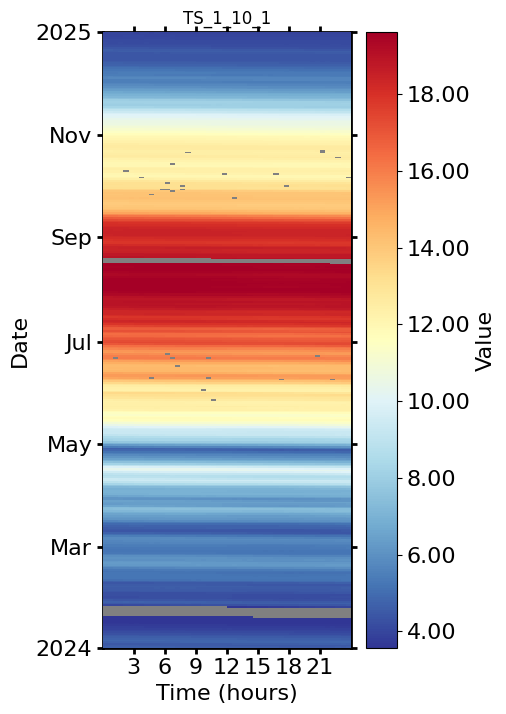

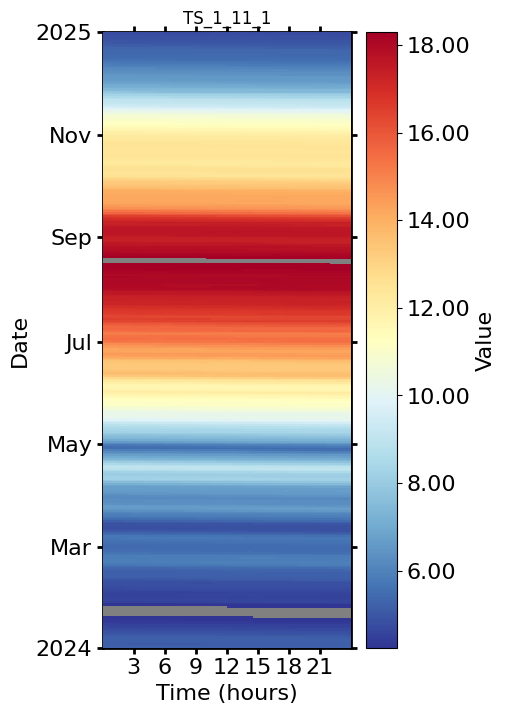

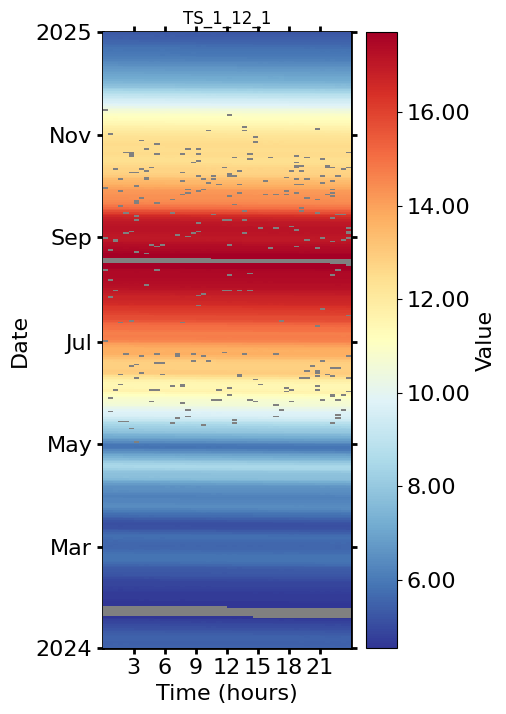

In [9]:
plotcols = [plotcol for plotcol in res.columns if not "TIMESTAMP" in plotcol]
plotdf = res[plotcols].copy()

for col in plotdf.columns:
    series = plotdf[col].copy()
    series.replace(to_replace=-9999, value=np.nan, inplace=True)
    try:
        fig = plt.figure(facecolor='white', figsize=(4, 8))
        gs = gridspec.GridSpec(1, 1)  # rows, cols
        ax = fig.add_subplot(gs[0, 0])
        vmin = series.quantile(.01)
        vmax = series.quantile(.99)
        HeatmapDateTime(ax=ax, series=series, vmin=vmin, vmax=vmax).plot()
        ax.set_title(col, color='black')
        fig.show()
    except TypeError:
        pass

</br>

# **Save to CSV**

In [10]:
f.export_yearly_files(site=SITE, outdir="")


Saving yearly CSV files ...
    --> Saved file ch-fru_2024_fluxes_meteo_20250226.csv.


</br>

# **End of notebook**

In [11]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-02-26 17:30:17
